In [1]:
import xarray
import pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

In [3]:
nino34Domain=_index.sstIndex['nino34']

nino34Domain

{'latMin': -5, 'latMax': 5, 'longMin': 190, 'longMax': 240}

In [4]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino34Box={
    'xy':[nino34Domain['longMin']-mapCentre, nino34Domain['latMin']],
    'width':nino34Domain['longMax']-nino34Domain['longMin'],
    'height':nino34Domain['latMax']-nino34Domain['latMin']
}

nino34Box

{'xy': [-20, -5], 'width': 50, 'height': 10}

# Load the sst dataset

In [5]:
paths = !find /scratch/w35/as2285/ersst/*.nc

In [6]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [7]:
sstClimat=sst.calculateClimatology(sstXr.sst)

In [8]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [9]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [10]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables:
    nino4                   (year) float64 0.4491 0.2838 ... 0.4623 -0.6939
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    eastIO                  (year) float64 -0.1259 0.4451 ... -1.003 0.1331
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    nino3                   (year) float64 1.068 0.02561 ... -0.3024 -0.8708
    nino34                  (year) float64 1.198 0.3367 ... -0.02116 -1.019
    westIO                  (year) float64 -0.3837 -0.211 ... 0.438 0.1493
    dmi                     (year) float64 -0.2578 -0.656 ... 1.441 0.01628
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    westIONoDetrend         (year) float64 -0.4674 -0.3855 ... 0.8908 0.4204
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275

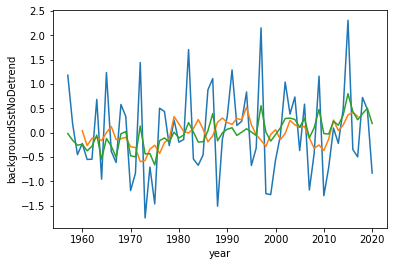

In [11]:
indexXr.nino34NoDetrend.plot()
indexXr.nino34NoDetrend.rolling(year=7,center=True).mean('year').plot()
indexXr.backgroundSstNoDetrend.plot()

In [12]:
# and EC index too
sstAnoms=ec.sstAnoms(sstXr.sst, sstXr.sst)

#create the solver
solver=ec.eofSolver(sstAnoms)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

In [13]:
pcXr=pcXr/pcXr.std()

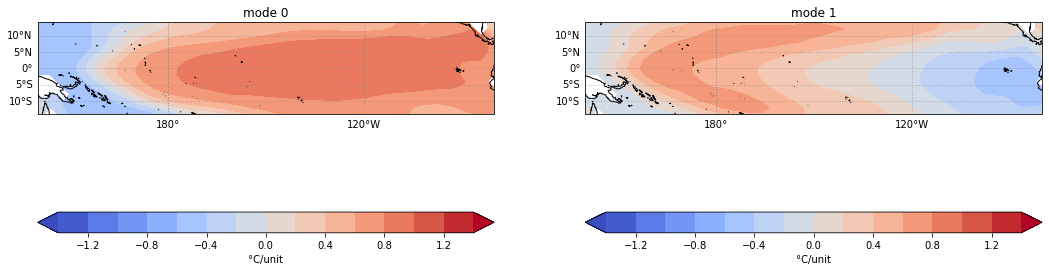

In [14]:
multiplyBy=[-1,1]

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=mapCentre))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

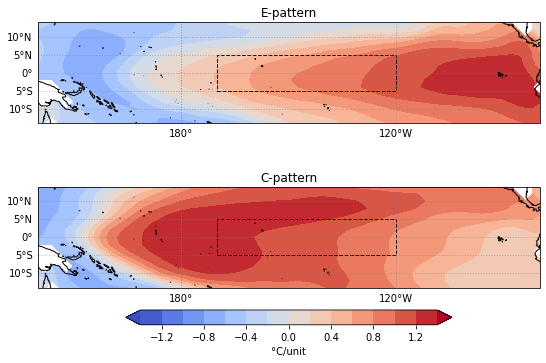

In [15]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(2,1,1,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax, colorbar=False)
ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))

plt.draw()
plt.title("E-pattern")

ax=fig.add_subplot(2,1,2,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
plt.title("C-pattern")
plt.savefig('results/ecPattern.png')
plt.show()


In [16]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

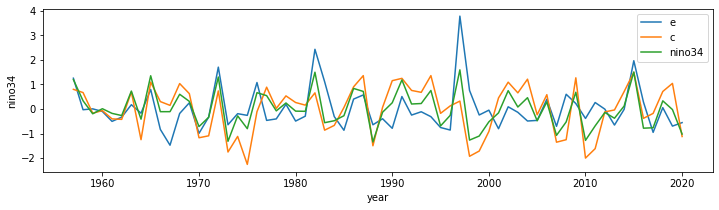

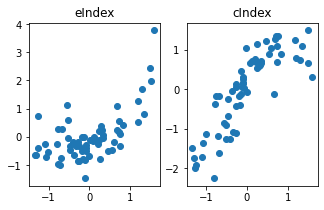

In [17]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.cIndex.plot()
indexXr.nino34.plot()

#plt.xlim([1950,2050])
plt.legend(['e','c','nino34'])
plt.show()

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino34, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino34, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [18]:
marshallPd=pandas.read_csv(
    'ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [19]:
marshallPd

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
1957,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78
2020,0.57,-0.36,2.05,-1.72,1.03,1.18,-0.97,-2.20,-0.25,1.79,1.14,2.28


In [20]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [21]:
indexXr['samSummer']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['OCT','NOV','DEC']
    ).sum('month')  #This is the sep to dec sum for each year
    + marshallXr.sel(
        year=range(1958,2022),
        month=['JAN','FEB','MAR']
    ).sum('month')   #This is the jan feb sum for the next year
)/6

indexXr['samWinter']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['APR','MAY','JUN','JUL','AUG','SEP']
    ).sum('month') 
)/6

In [22]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables: (12/15)
    nino4                   (year) float64 0.4491 0.2838 ... 0.4623 -0.6939
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    eastIO                  (year) float64 -0.1259 0.4451 ... -1.003 0.1331
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    nino3                   (year) float64 1.068 0.02561 ... -0.3024 -0.8708
    nino34                  (year) float64 1.198 0.3367 ... -0.02116 -1.019
    ...                      ...
    westIONoDetrend         (year) float64 -0.4674 -0.3855 ... 0.8908 0.4204
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275
    eIndex                  (year) float64 1.255 -0.0279 ... -0.6954 -0.553
    cIndex                  (year) float64 0.8027 0.6715 ... 1.045 -1.119
    samSummer               (year) float64 nan -0.7267 0.55 ... -0.9633 1.245
    samWinter               (year) float64 -0.8917 -0.4617 ... -0.07833 -0.4883

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [23]:
stdXr=indexXr.std()

In [25]:
criteriaXr=stdXr[['dmi','nino34', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samWinter']=stdXr.samWinter/2
criteriaXr['samSummer']=stdXr.samSummer/2

In [26]:
criteriaXr

<xarray.Dataset>
Dimensions:    ()
Data variables:
    dmi        float64 0.4737
    nino34     float64 0.7333
    eastIO     float64 0.388
    eIndex     float64 0.8558
    cIndex     float64 0.9766
    samWinter  float64 0.4147
    samSummer  float64 0.4317

In [27]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['eIndex', 'samWinter', 'nino34', 'dmi', 'cIndex']
fireNeg: 
['samSummer', 'eastIO']


In [28]:
firePosXr

<xarray.Dataset>
Dimensions:    (year: 64)
Coordinates:
  * year       (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
Data variables:
    eIndex     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    samWinter  (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 0.0
    nino34     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dmi        (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 1.0 0.0
    cIndex     (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    samSummer  (year) float64 nan 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    eastIO     (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0 0.0

In [29]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [30]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [31]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 1.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    cIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    samSummer   (fire, year) float64 nan 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [32]:
eventsXr.to_netcdf('results/obsEvents.nc')

In [33]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 1.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    cIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    samSummer   (fire, year) float64 nan 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [34]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

eIndex : [1957 1972 1976 1982 1983 1997 2015]
samWinter : [1967 1969 1976 1978 1979 1982 1985 1989 1993 1997 1998 1999 2001 2003
 2004 2005 2008 2010 2012 2015 2016 2017]
nino34 : [1957 1965 1972 1982 1986 1991 1994 1997 2002 2015]
dmi : [1961 1963 1967 1972 1994 1997 2006 2012 2015 2018 2019]
cIndex : [1965 1968 1987 1990 1991 1994 2002 2004 2009 2015 2019]
samSummer : [1958 1964 1965 1966 1967 1968 1969 1970 1972 1975 1976 1977 1980 1984
 1986 1987 1988 2002 2004 2019]
eastIO : [1961 1963 1972 1994 1997 2006 2019]
ecCombined : [1957 1965 1968 1972 1976 1982 1983 1987 1990 1991 1994 1997 2002 2004
 2009 2015 2019]


Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (bad)


# Check events against the initial SSTs:

In [35]:
ensoSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='nino34'))
iodSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='dmi'))

In [36]:
%run helpers/impactPlots.ipynb

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>]

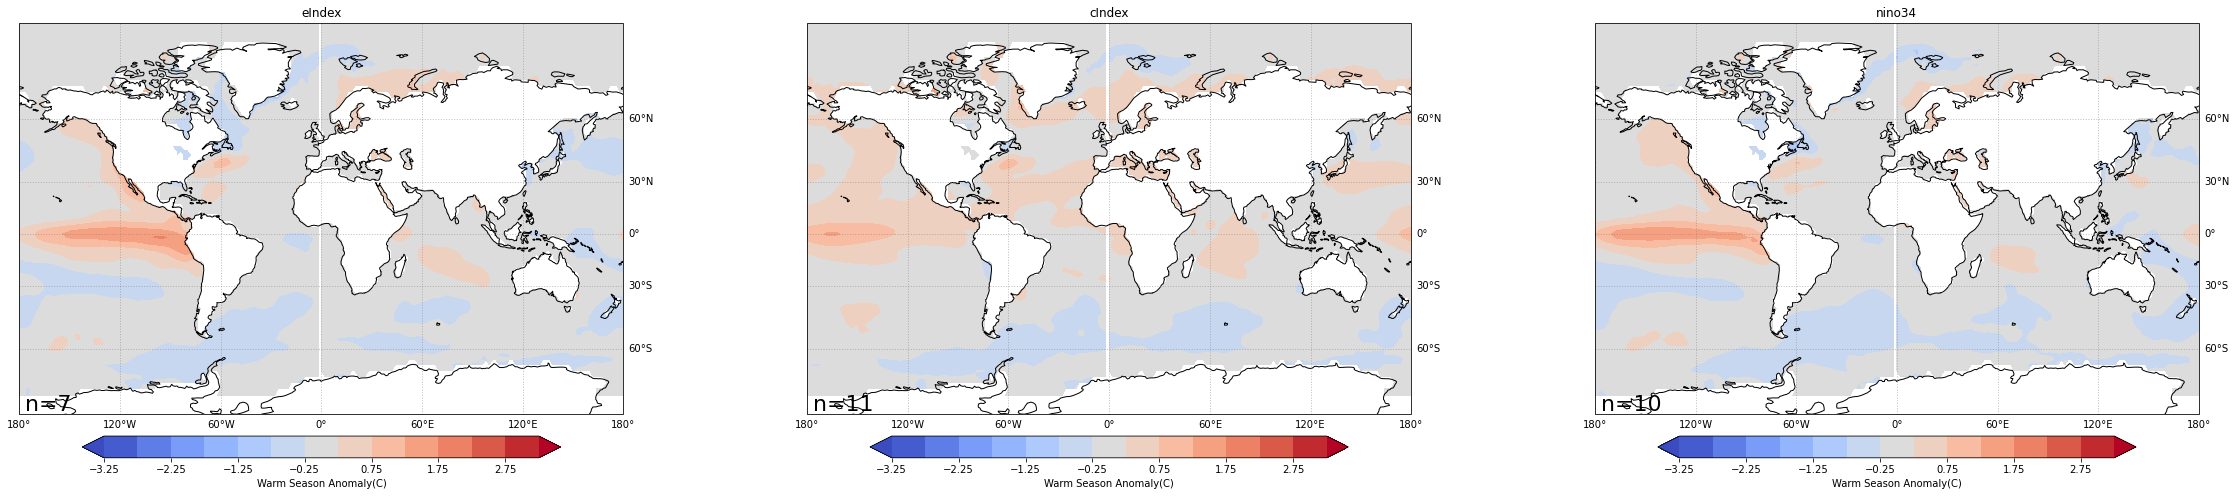

In [40]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['eIndex','cIndex','nino34'],
    showOcean=True
)

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>]

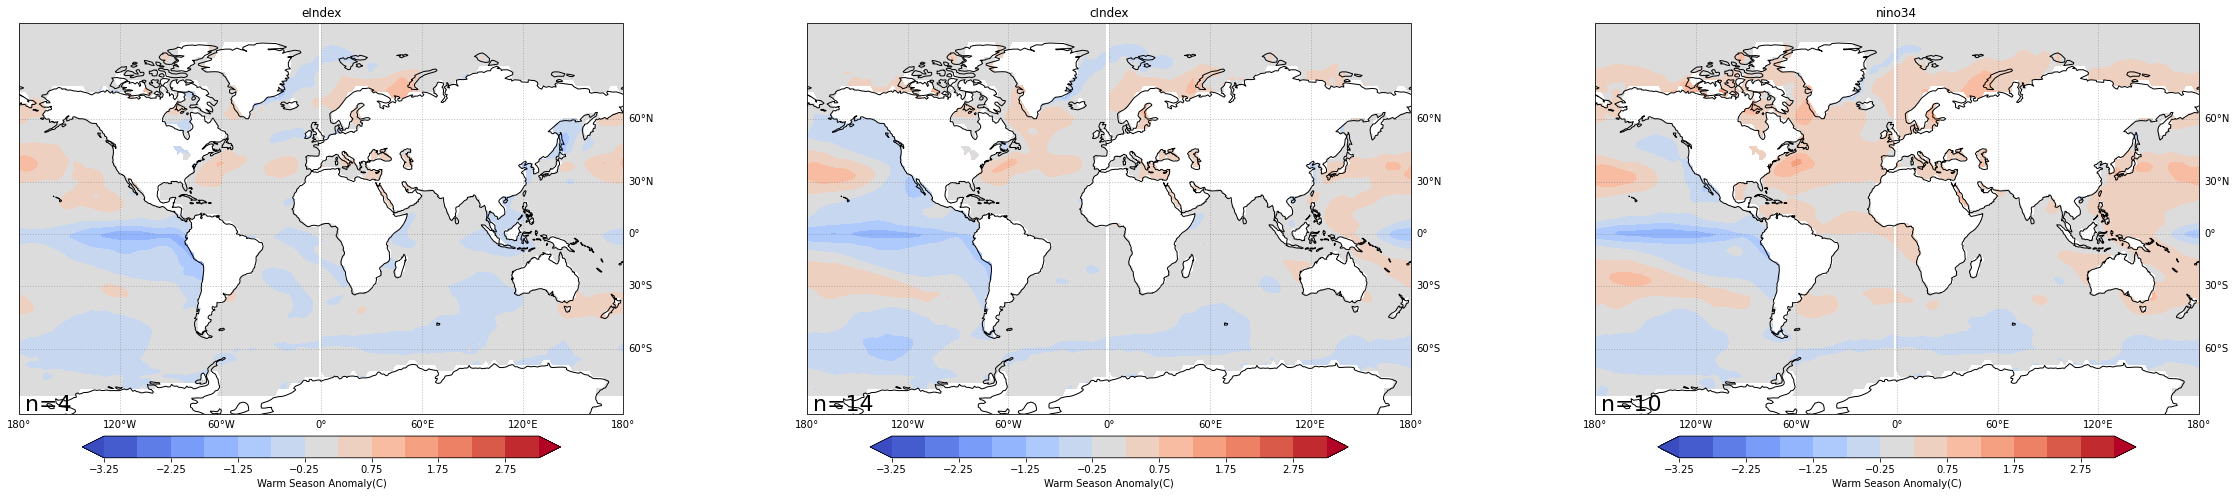

In [41]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['eIndex','cIndex','nino34'],
    showOcean=True
)

[<GeoAxesSubplot:title={'center':'dmi'}>]

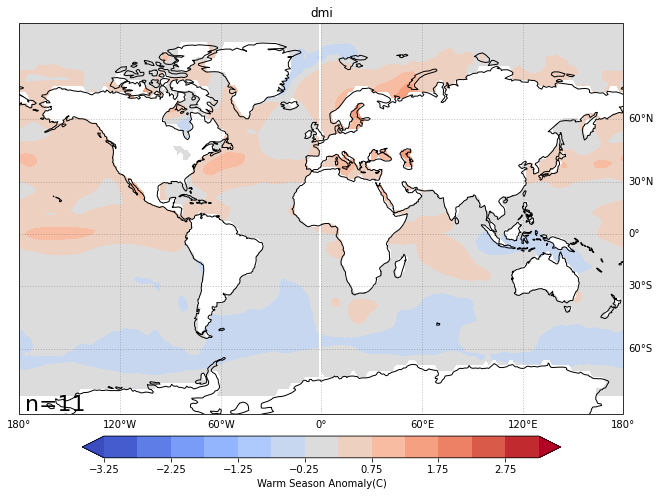

In [42]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['dmi'],
    showOcean=True
)

[<GeoAxesSubplot:title={'center':'dmi'}>]

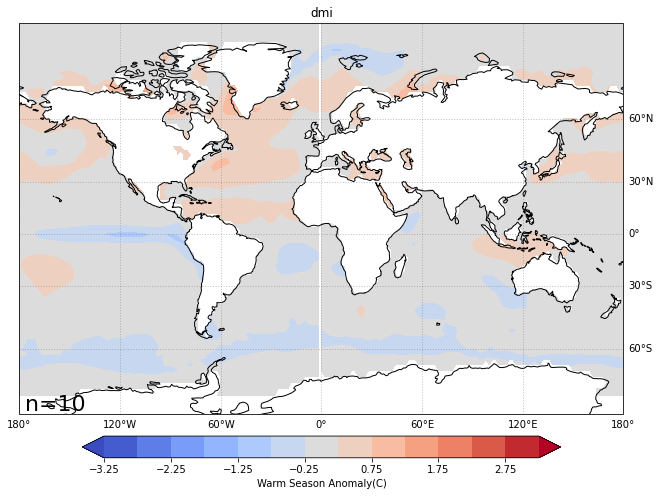

In [43]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['dmi'],
    showOcean=True
)

# If we plot some impact maps now, do they look plausible?

In [44]:
eventsXr=xarray.load_dataset('results/obsEvents.nc')

In [45]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire        (fire) object 'pos' 'neg'
Data variables:
    eIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 0.0 1.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    cIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    samSummer   (fire, year) float64 nan 1.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [46]:
prTWarmSeasonXr = xarray.load_dataset('results/observPrTmaxAnoms.nc')

In [47]:
prTWarmSeasonXr

<xarray.Dataset>
Dimensions:       (lat: 691, lon: 886, year: 120)
Coordinates:
  * lat           (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon           (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * year          (year) int64 1900 1901 1902 1903 1904 ... 2016 2017 2018 2019
Data variables:
    tsAnomWinter  (year, lat, lon) float32 nan nan nan ... -0.03632 -0.03523
    tsAnomSummer  (year, lat, lon) float32 nan nan nan ... 0.04448 0.04579
    prAnomWinter  (year, lat, lon) float64 5.921e-16 0.0 ... 0.0004324 0.0004152
    prAnomSummer  (year, lat, lon) float64 0.0004444 0.000446 ... -0.06802
    prWinter      (lat, lon) float64 11.01 11.0 11.0 10.99 ... 5.803 5.816 5.827
    prSummer      (lat, lon) float64 2.243 2.243 2.243 ... 9.215 9.224 9.23
    tsWinter      (lat, lon) float32 11.12 11.13 11.13 ... 28.14 28.13 28.12
    tsSummer      (lat, lon) float32 8.469 8.476 8.482 ... 29.48 29.47 29.46

In [48]:
eventsLs = {
    'summer':['eIndex', 'cIndex', 'ecCombined', 'nino34','dmi','samSummer'],
    'winter':['eIndex', 'cIndex', 'ecCombined', 'nino34','dmi','samWinter']
}

# Anoms for indiv indices

In [49]:
%run helpers/impactPlots.ipynb

pos
winter


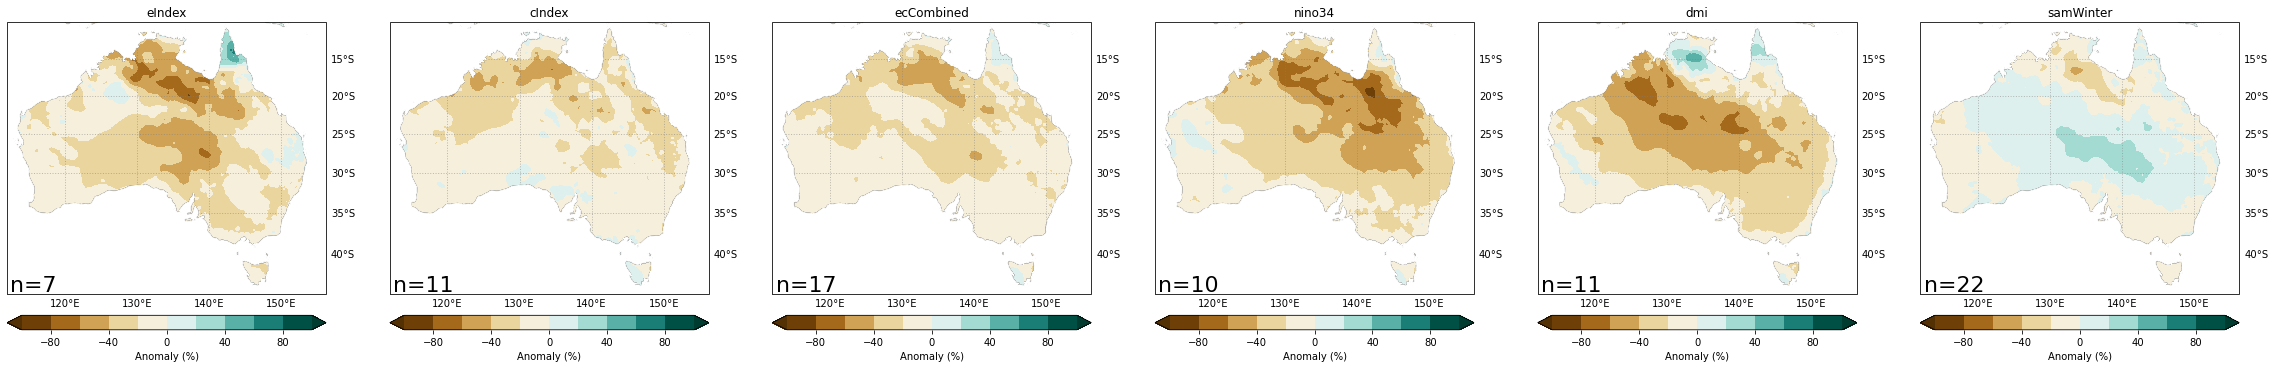

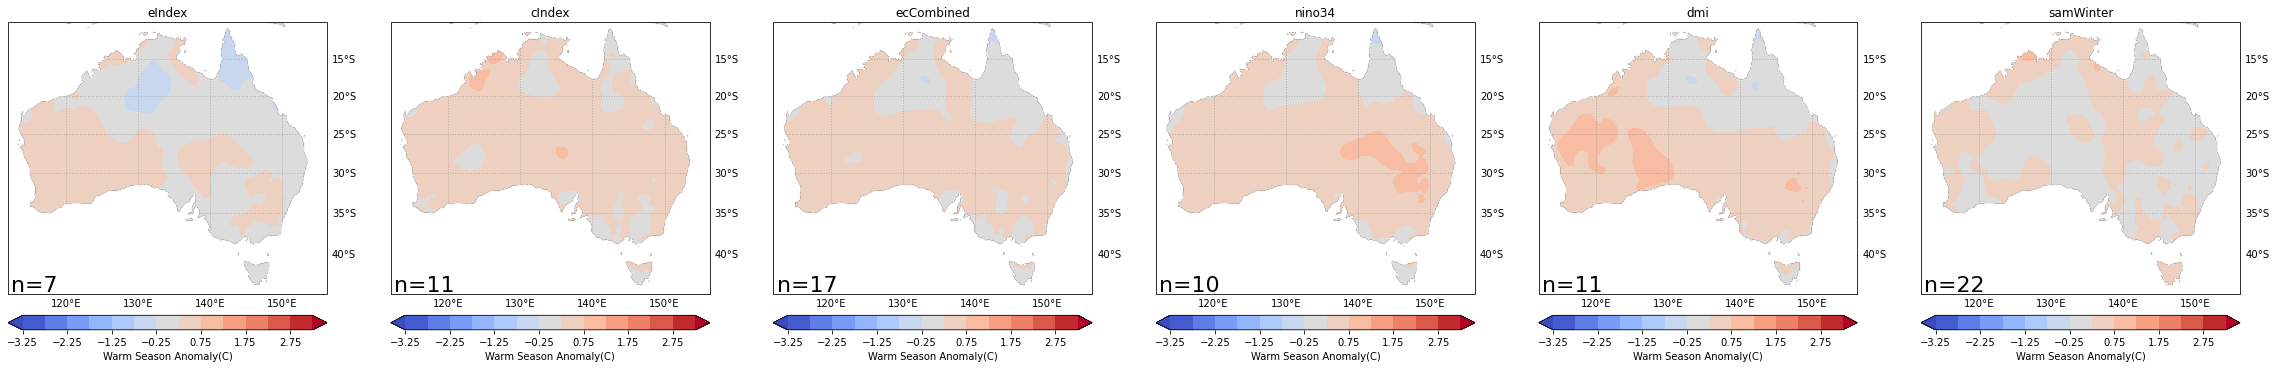

summer


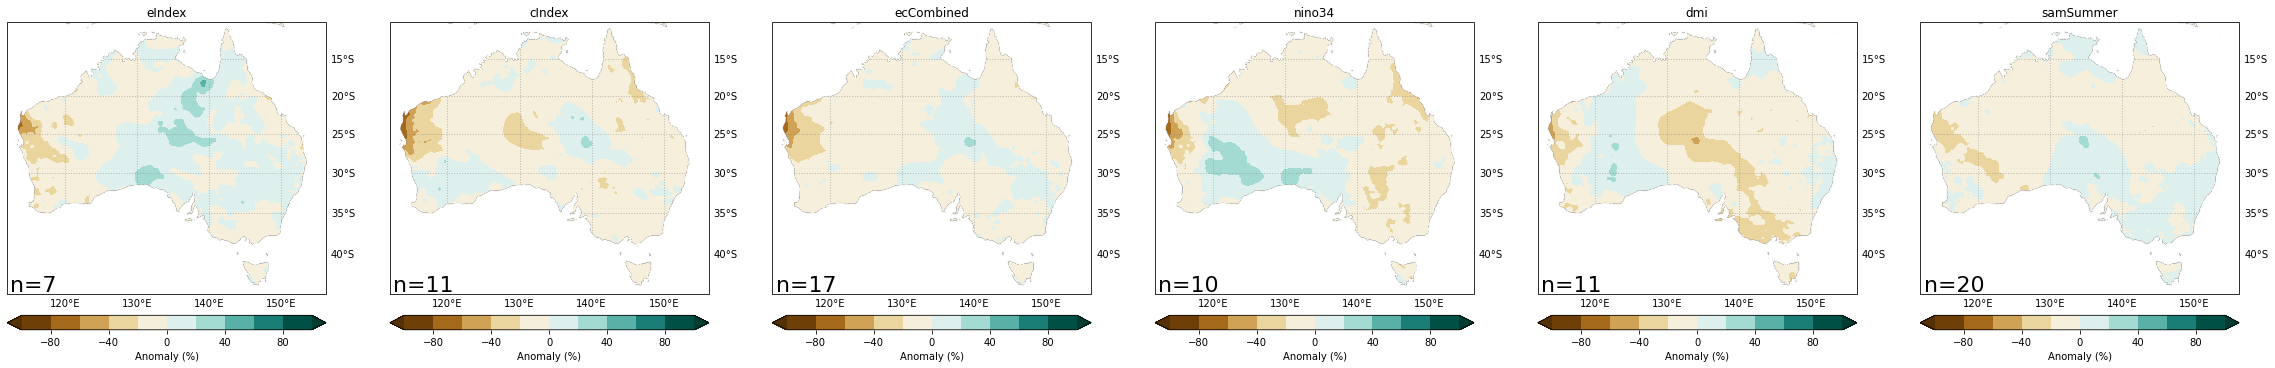

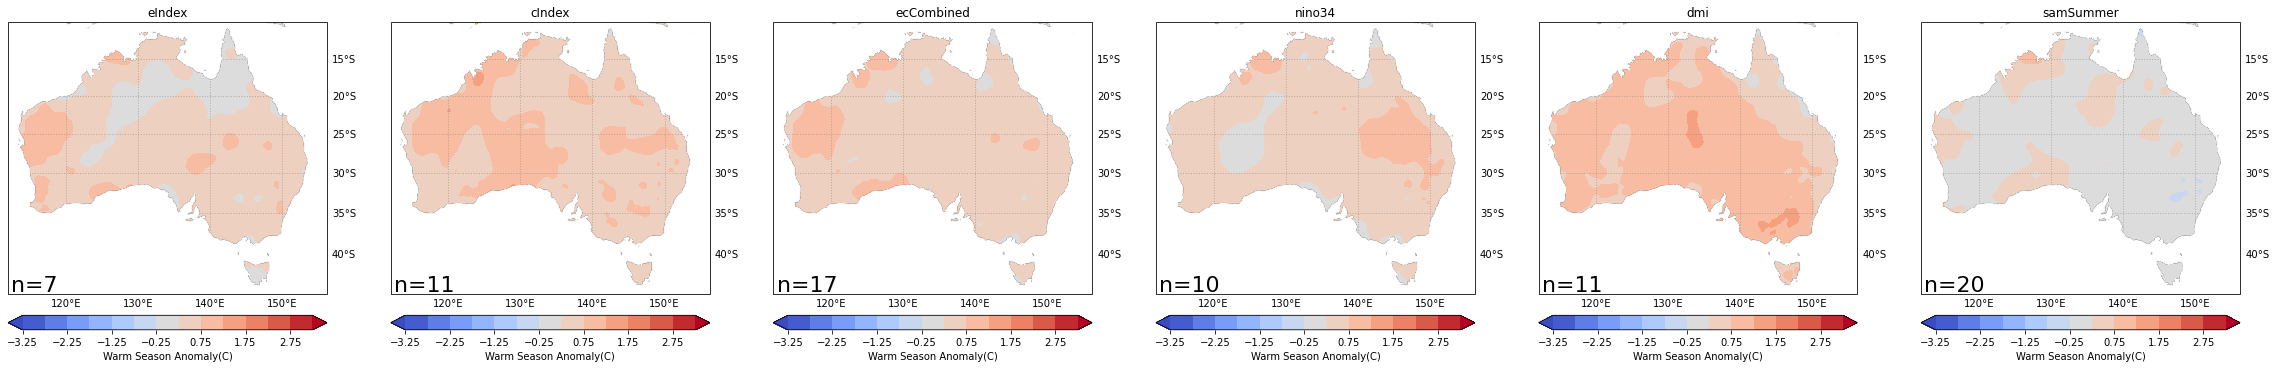

neg
winter


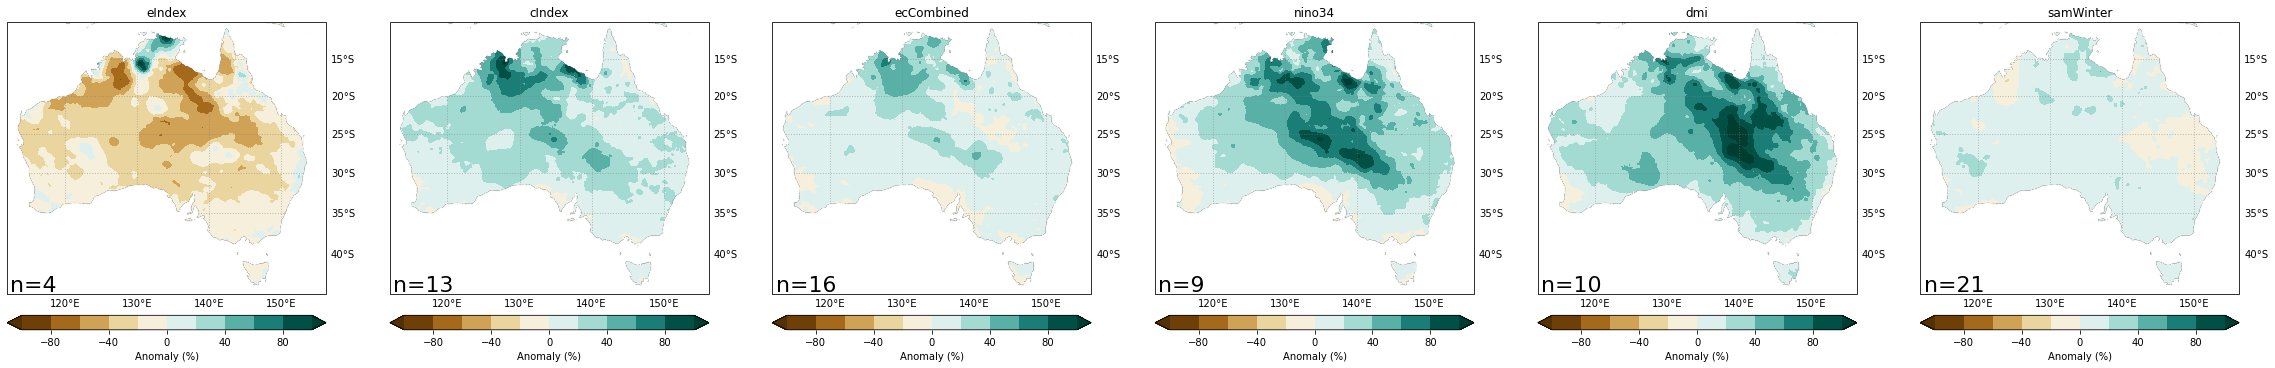

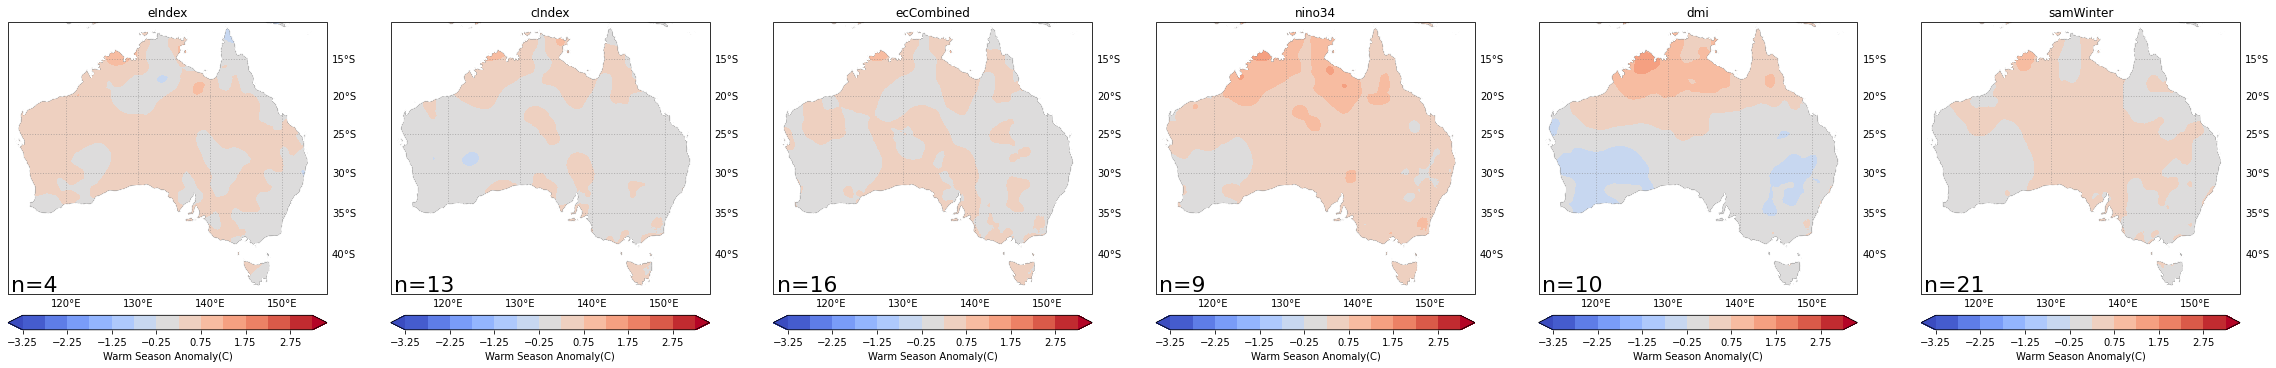

summer


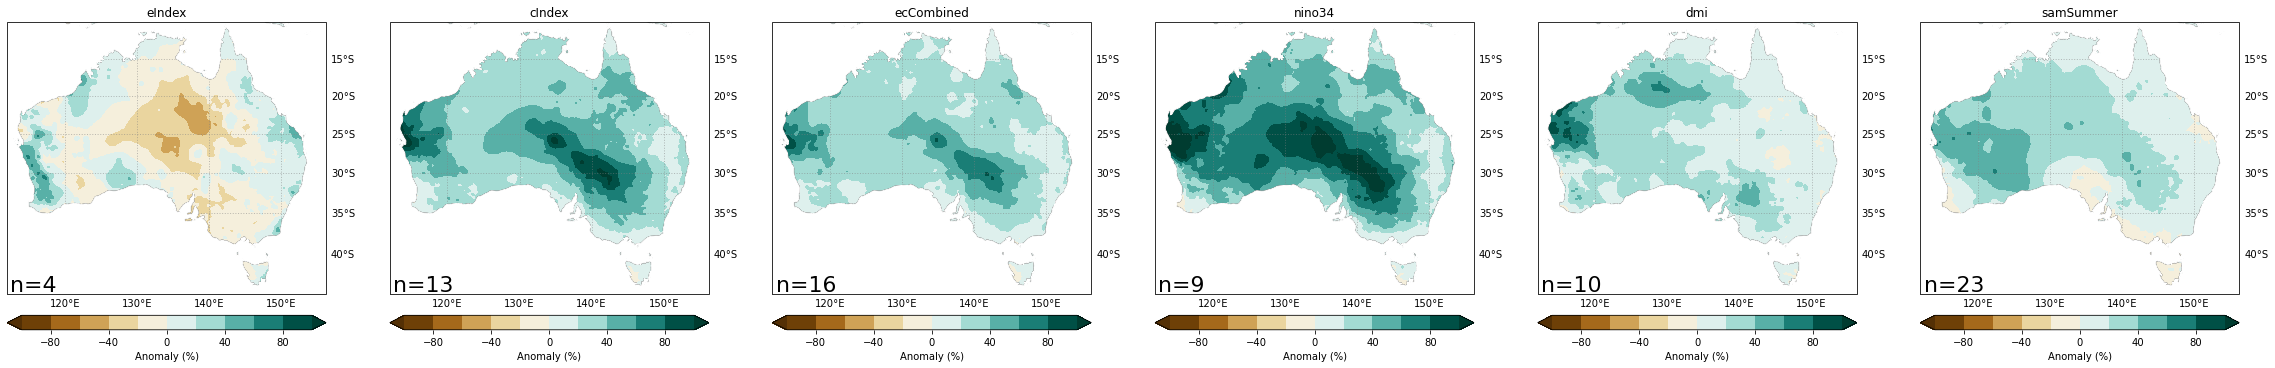

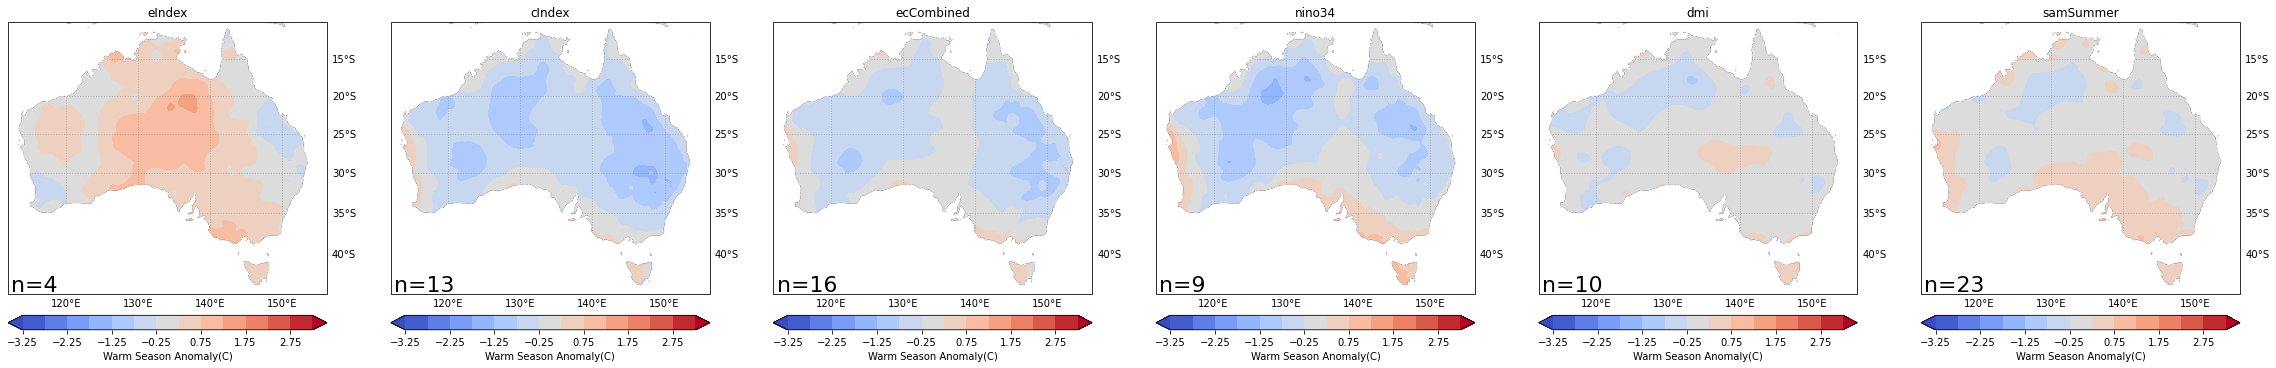

In [51]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            showOcean=False
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            showOcean=False
        )
        plt.show()

# Compound them and see what happens

In [52]:
compoundEventsXr=compound.compound(eventsXr)

eIndexDmiSamsummer
eIndexDmiSamwinter
eIndexEastioSamsummer
eIndexEastioSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter
cIndexEastioSamsummer
cIndexEastioSamwinter
nino34DmiSamsummer
nino34DmiSamwinter
nino34EastioSamsummer
nino34EastioSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
ecCombinedEastioSamsummer
ecCombinedEastioSamwinter


In [53]:
indexSet='ecCombinedDmiSam'

In [54]:
compoundEventsLs=[*compoundEventsXr.indeces,*compoundEventsXr.pairs, 'all3']

In [55]:
compoundEventsLs

['enso', 'iod', 'sam', 'enso+iod', 'enso+sam', 'iod+sam', 'all3']

In [58]:
#enso+iod compound years, realWorld


pos
winter


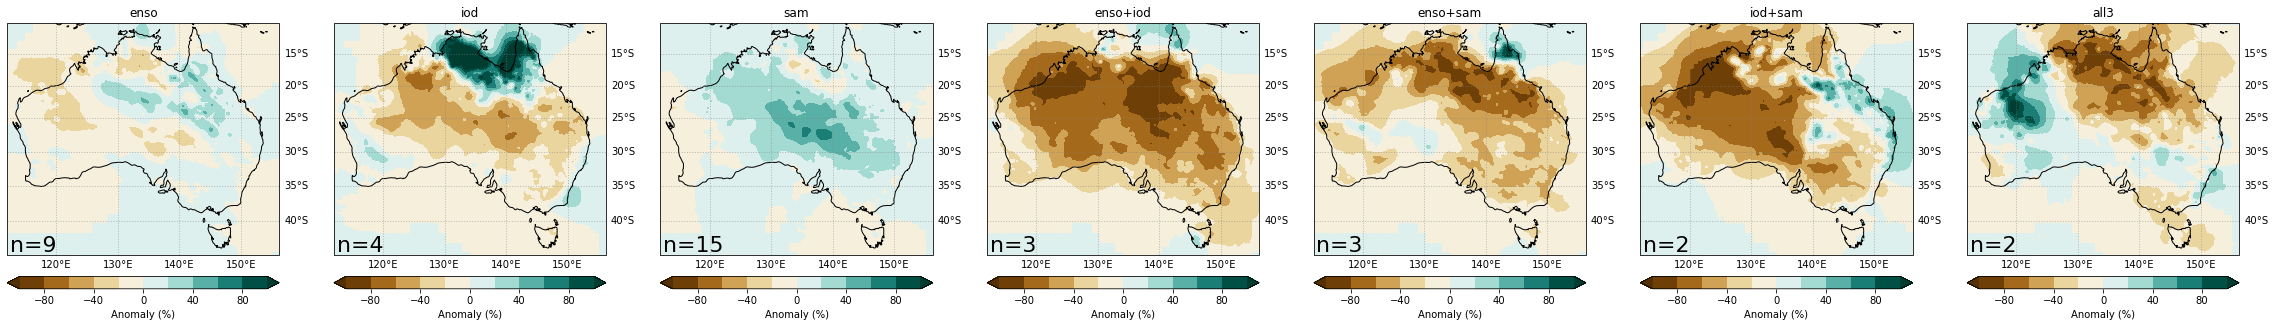

KeyError: 'ecCombinedDmiSam'

In [59]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            compoundEventsXr['ecCombinedDmiSam'+iSeason].sel(fire=iFire, drop=True).to_dataset('compound'), 
            compoundEventsLs
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            compoundEventsXr[indexSet].sel(fire=iFire, drop=True).to_dataset('compound'), 
            compoundEventsLs
        )
        plt.show()

# And comparison between the three enso indices

In [ ]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

In [ ]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [ ]:
ensoIodEventsLs

In [ ]:
ensoIodEventLs=[
    'ecCombinedDmiSam',
    'cIndexDmiSam',
    'eIndexDmiSam',
    'nino34DmiSam'
]


In [ ]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()